In [91]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import seaborn as sb

In [92]:
import tensorflow

In [94]:
os.listdir('dataset')

['application_test.csv',
 'HomeCredit_columns_description.csv',
 'POS_CASH_balance.csv',
 'credit_card_balance.csv',
 'installments_payments.csv',
 'application_train.csv',
 'bureau.csv',
 'previous_application.csv',
 'bureau_balance.csv',
 'sample_submission.csv']

In [95]:
dataset_test = pd.read_csv('dataset/application_test.csv')
dataset_train = pd.read_csv('dataset/application_train.csv')
dataset_hc_c_d = pd.read_csv('dataset/HomeCredit_columns_description.csv',encoding="ISO-8859-1")
dataset_pos_cash_b = pd.read_csv('dataset/POS_CASH_balance.csv')
dataset_ins_pay = pd.read_csv('dataset/installments_payments.csv')
dataset_c_c_bal = pd.read_csv('dataset/credit_card_balance.csv')
dataset_br = pd.read_csv('dataset/bureau.csv')
dataset_prev_app = pd.read_csv('dataset/previous_application.csv')
dataset_br_bal = pd.read_csv('dataset/bureau_balance.csv')

In [96]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [97]:
dataset_train['FLAG_DOCUMENT_18'].isnull().sum()

0

In [98]:
dataset_train['FLAG_DOCUMENT_19'].isnull().sum()

0

In [99]:
dataset_train['FLAG_DOCUMENT_20'].isnull().sum()

0

In [100]:
dataset_train.shape

(307511, 122)

In [101]:
dataset_train = dataset_train.dropna(axis='columns')

In [103]:
dataset_train.shape

(307511, 55)

In [104]:
dataset_train.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,1,1,0,1,1,0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,1,1,0,1,1,0,1,1,MONDAY,11,0,0,0,0,0,0,School,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,1,1,1,1,1,0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,1,1,0,1,0,0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,1,1,0,1,0,0,2,2,THURSDAY,11,0,0,0,0,1,1,Religion,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
5,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,State servant,Secondary / secondary special,Married,House / apartment,0.035792,-16941,-1588,-4970.0,-477,1,1,1,1,1,0,2,2,WEDNESDAY,16,0,0,0,0,0,0,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,100009,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,Commercial associate,Higher education,Married,House / apartment,0.035792,-13778,-3130,-1213.0,-619,1,1,0,1,1,0,2,2,SUNDAY,16,0,0,0,0,0,0,Business Entity Type 3,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
7,100010,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,State servant,Higher education,Married,House / apartment,0.003122,-18850,-449,-4597.0,-2379,1,1,1,1,0,0,3,3,MONDAY,16,0,0,0,0,1,1,Other,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,100011,0,Cash loans,F,N,Y,0,112500.0,1019610.0,Pensioner,Secondary / secondary special,Married,House / apartment,0.018634,-20099,365243,-7427.0,-3514,1,0,0,1,0,0,2,2,WEDNESDAY,14,0,0,0,0,0,0,XNA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,100012,0,Revolving loans,M,N,Y,0,135000.0,405000.0,Working,Secondary / secondary special,Single / not married,House / apartment,0.019689,-14469,-2019,-14437.0,-3992,1,1,0,1,0,0,2,2,THURSDAY,8,0,0,0,0,0,0,Electricity,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [105]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    282686
1     24825
Name: SK_ID_CURR, dtype: int64

In [106]:
#Using random under sampling to handle imbalanced dataset
under_sampled_dataset_train_0 = dataset_train[dataset_train.TARGET == 0].sample(30000)
under_sampled_dataset_train_1 = dataset_train[dataset_train.TARGET == 1].sample(20000)
dataset_train = pd.concat([under_sampled_dataset_train_0,under_sampled_dataset_train_1],ignore_index=True)

In [108]:
dataset_train.shape

(50000, 55)

In [109]:
dataset_train.groupby('TARGET')['SK_ID_CURR'].nunique()

TARGET
0    30000
1    20000
Name: SK_ID_CURR, dtype: int64

In [110]:
dataset_train = dataset_train.sample(frac=1).reset_index(drop=True)

In [111]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,300594,0,Cash loans,F,Y,Y,0,67500.0,521280.0,Working,Secondary / secondary special,Married,House / apartment,0.022800,-14541,-479,-6665.0,-4423,1,1,1,1,1,0,2,2,WEDNESDAY,11,0,0,0,0,1,1,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,226993,0,Cash loans,F,Y,Y,0,112500.0,953460.0,Working,Higher education,Married,House / apartment,0.004960,-14865,-2899,-1984.0,-471,1,1,0,1,1,0,2,2,SATURDAY,14,0,0,0,0,0,0,Kindergarten,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,402717,0,Cash loans,F,N,N,2,135000.0,1288350.0,Working,Secondary / secondary special,Separated,House / apartment,0.022800,-13027,-5106,-5988.0,-4548,1,1,0,1,0,0,2,2,FRIDAY,14,0,0,0,0,0,0,Kindergarten,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,326951,1,Cash loans,M,Y,Y,0,157500.0,379008.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.009334,-19854,-3779,-1981.0,-3068,1,1,1,1,1,0,2,2,FRIDAY,12,0,0,0,0,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,304722,0,Cash loans,F,N,Y,0,67500.0,325908.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.010276,-22458,365243,-8020.0,-4835,1,0,0,1,1,0,2,2,WEDNESDAY,11,0,0,0,0,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [112]:
dataset_test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

In [113]:
dataset_hc_c_d.head()

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


In [114]:
dataset_pos_cash_b.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [115]:
dataset_ins_pay.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [116]:
dataset_c_c_bal.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


In [117]:
dataset_br.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [118]:
dataset_prev_app.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [119]:
dataset_br_bal.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [120]:
dataset_train = dataset_train.dropna(axis='rows')

In [121]:
dataset_train["TARGET"].value_counts(dropna=False)

0    30000
1    20000
Name: TARGET, dtype: int64

In [122]:
corr = dataset_train.corr(method='pearson')

In [123]:
corr

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
SK_ID_CURR,1.000000,-0.003913,-0.000995,-0.001704,-0.000017,0.002612,0.002283,-0.003311,0.007048,-0.002445,NaN,0.003258,0.007645,-0.002200,0.009502,0.001856,-0.005851,-0.006213,0.010630,-0.002521,0.001450,0.003067,0.001849,-0.001838,-0.004007,-0.001645,0.000378,0.002071,-0.005839,-0.001110,0.000318,0.001808,0.000383,-0.000040,-0.001158,NaN,-0.004181,0.001296,0.005419,-0.003244,-0.003570,-0.005996,0.001218,-0.000412,0.008129
TARGET,-0.003913,1.000000,0.035289,-0.035506,-0.060290,-0.069051,0.145256,-0.087691,0.073259,0.091479,NaN,0.089609,0.051430,-0.000546,-0.040259,-0.000460,0.107845,0.112372,-0.045065,0.006048,0.015400,0.009665,0.077864,0.088879,0.053649,0.010955,0.076926,-0.008165,-0.000600,-0.051026,-0.002760,-0.015886,-0.005453,-0.006325,-0.005701,NaN,-0.020705,-0.018459,-0.012813,-0.022246,-0.002760,-0.020844,-0.008336,-0.002906,0.007173
CNT_CHILDREN,-0.000995,0.035289,1.000000,0.016772,0.001311,-0.029906,0.308363,-0.225879,0.172077,-0.024514,NaN,0.226679,0.057781,-0.004497,-0.027792,0.018528,0.031648,0.033111,-0.011204,-0.015472,0.001320,0.007777,0.014219,0.065900,0.065640,-0.005287,0.057470,-0.005912,-0.018572,-0.147554,0.002259,0.047881,-0.005368,-0.004579,-0.005930,NaN,0.001648,-0.004758,0.000399,0.006875,-0.000054,0.007063,-0.001070,-0.000889,0.002578
AMT_INCOME_TOTAL,-0.001704,-0.035506,0.016772,1.000000,0.269389,0.117283,0.031167,-0.102753,0.044316,0.009406,NaN,0.102004,-0.034614,-0.014431,0.000616,0.070109,-0.138728,-0.149475,0.073153,0.067234,0.113618,0.102636,0.010686,0.012361,0.014107,0.000599,-0.033535,-0.000501,0.001892,-0.073707,0.005621,0.127651,0.029802,-0.000104,-0.000255,NaN,0.042144,0.031898,0.019317,0.018620,0.004283,0.012949,0.002062,-0.001147,0.000096
AMT_CREDIT,-0.000017,-0.060290,0.001311,0.269389,1.000000,0.085242,-0.081925,-0.047038,-0.002796,-0.017628,NaN,0.045311,-0.031235,0.032969,0.018165,0.013674,-0.083553,-0.094335,0.048557,0.024920,0.041436,0.035292,-0.029834,-0.033813,-0.013944,0.021078,0.073071,-0.006140,-0.008667,-0.030943,-0.002390,0.083686,0.028839,-0.005752,0.025794,NaN,0.045803,0.051369,0.030556,0.067569,0.016083,0.035371,0.018694,0.031611,-0.016490
REGION_POPULATION_RELATIVE,0.002612,-0.069051,-0.029906,0.117283,0.085242,1.000000,-0.036805,0.001730,-0.059825,-0.001773,NaN,-0.002069,-0.016832,-0.016647,0.086145,0.032237,-0.503252,-0.503584,0.161712,-0.009441,0.042772,0.065715,-0.054617,-0.044604,-0.017023,-0.004355,-0.072616,0.003538,0.010584,0.004126,-0.000999,0.074396,0.027553,0.003043,0.022806,NaN,0.030949,0.032829,-0.001351,0.005282,0.002079,0.010549,0.005435,-0.003417,0.006480
DAYS_BIRTH,0.002283,0.145256,0.308363,0.031167,-0.081925,-0.036805,1.000000,-0.605623,0.316955,0.278452,NaN,0.609530,0.173231,-0.019671,-0.040422,0.075641,0.020801,0.020129,0.082709,0.059541,0.089598,0.066424,0.176905,0.244405,0.157089,-0.006936,0.118983,-0.000079,0.019198,-0.396382,0.001382,0.094952,0.011582,0.000577,0.038484,NaN,0.011049,0.029170,0.010871,0.012234,0.004194,0.037067,0.003392,-0.000023,0.030000
DAYS_EMPLOYED,-0.003311,-0.087691,-0.225879,-0.102753,-0.047038,0.001730,-0.605623,1.000000,-0.199322,-0.267061,NaN,-0.999743,-0.226597,0.014620,0.016834,-0.054767,0.020951,0.021876,-0.080665,-0.032199,-0.101061,-0.089418,-0.0902

In [124]:
type(corr)

pandas.core.frame.DataFrame

In [125]:
column_names = list(corr.columns.values)
columns_to_remove = []
for idx,row in corr.iterrows():
    for i in range(0,len(row)):
        if row[i] > 0.70:
            if idx != column_names[i] and idx not in columns_to_remove and column_names[i] not in columns_to_remove:
                columns_to_remove.append(idx)
                columns_to_remove.append(column_names[i])
                print(idx + " - " + column_names[i])
                print(row[i])

REGION_RATING_CLIENT - REGION_RATING_CLIENT_W_CITY
0.9547581828285914
REG_REGION_NOT_WORK_REGION - LIVE_REGION_NOT_WORK_REGION
0.8584882671094793
REG_CITY_NOT_WORK_CITY - LIVE_CITY_NOT_WORK_CITY
0.8112418455248324


In [126]:
#Columnd to remove die to high correlation
columns_to_remove

['REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

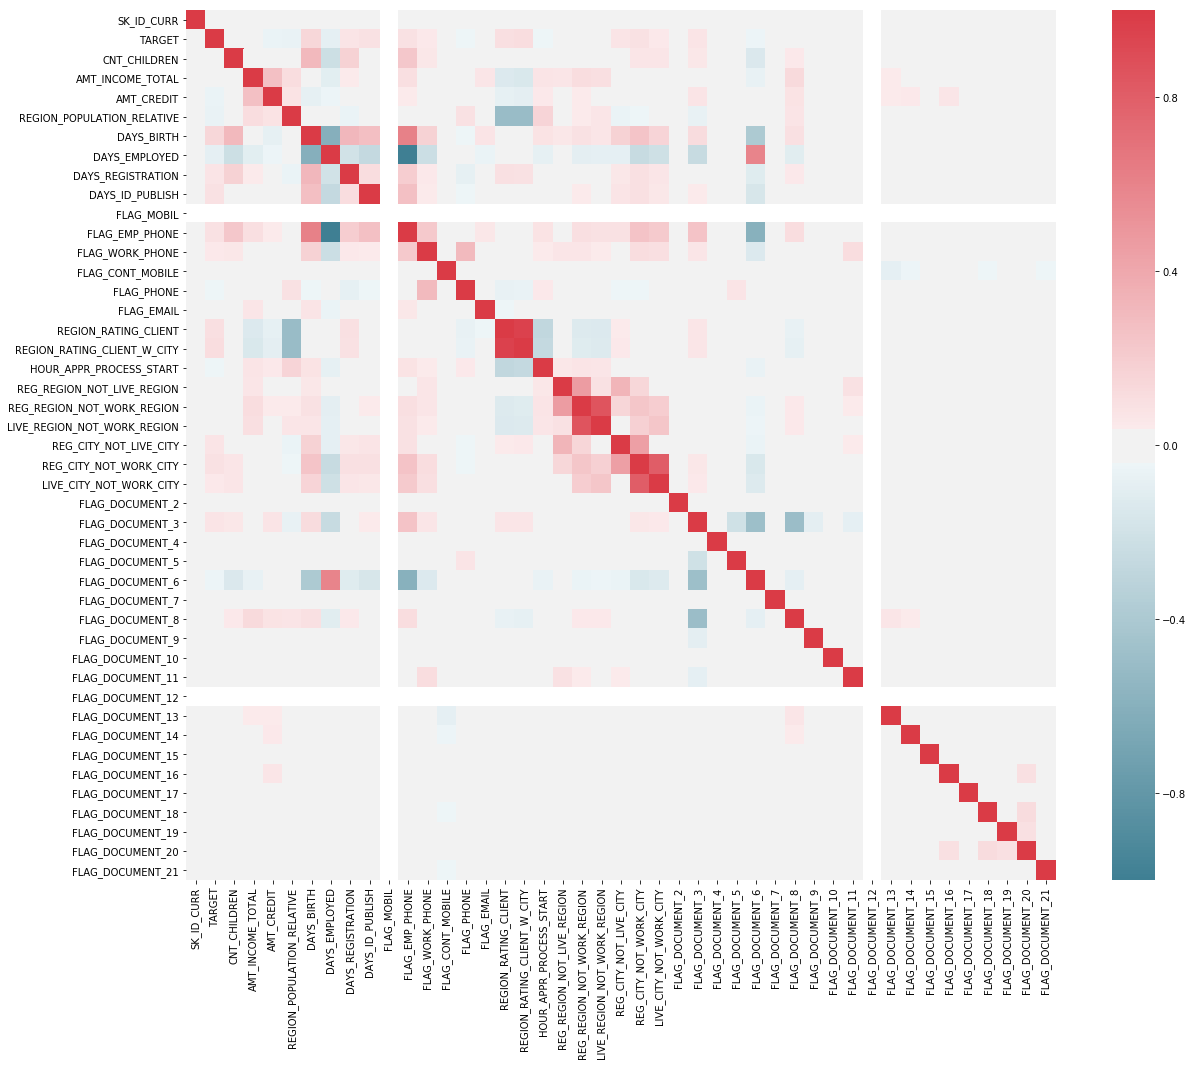

In [127]:
f,ax = plt.subplots(figsize=(20,16))
corr = dataset_train.corr()
corr_heatmap = sb.heatmap(corr,mask=np.zeros_like(corr,dtype=np.bool),cmap=sb.diverging_palette(220,10,as_cmap=True),square=True,ax=ax)
corr_figure = corr_heatmap.get_figure()
corr_figure.savefig("correlations_heatmap.png")

In [130]:
dataset_train = dataset_train.drop(columns_to_remove,axis=1)

KeyError: "['REGION_RATING_CLIENT' 'REGION_RATING_CLIENT_W_CITY'\n 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'\n 'REG_CITY_NOT_WORK_CITY' 'LIVE_CITY_NOT_WORK_CITY'] not found in axis"

In [131]:
dataset_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_CITY_NOT_LIVE_CITY,ORGANIZATION_TYPE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21
0,300594,0,Cash loans,F,Y,Y,0,67500.0,521280.0,Working,Secondary / secondary special,Married,House / apartment,0.022800,-14541,-479,-6665.0,-4423,1,1,1,1,1,0,WEDNESDAY,11,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,226993,0,Cash loans,F,Y,Y,0,112500.0,953460.0,Working,Higher education,Married,House / apartment,0.004960,-14865,-2899,-1984.0,-471,1,1,0,1,1,0,SATURDAY,14,0,0,Kindergarten,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,402717,0,Cash loans,F,N,N,2,135000.0,1288350.0,Working,Secondary / secondary special,Separated,House / apartment,0.022800,-13027,-5106,-5988.0,-4548,1,1,0,1,0,0,FRIDAY,14,0,0,Kindergarten,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,326951,1,Cash loans,M,Y,Y,0,157500.0,379008.0,Working,Secondary / secondary special,Civil marriage,House / apartment,0.009334,-19854,-3779,-1981.0,-3068,1,1,1,1,1,0,FRIDAY,12,0,0,Self-employed,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,304722,0,Cash loans,F,N,Y,0,67500.0,325908.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,0.010276,-22458,365243,-8020.0,-4835,1,0,0,1,1,0,WEDNESDAY,11,0,0,XNA,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [132]:
pd.set_option('display.max_columns',None)

In [136]:
dataset_train.head()

,AMT_CREDIT,AMT_INCOME_TOTAL,CNT_CHILDREN,CODE_GENDER_0,CODE_GENDER_1,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_REGISTRATION,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLAG_PHONE,FLAG_WORK_PHONE,HOUR_APPR_PROCESS_START,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,ORGANIZATION_TYPE,REGION_POPULATION_RELATIVE,REG_CITY_NOT_LIVE_CITY,REG_REGION_NOT_LIVE_REGION,SK_ID_CURR,TARGET,WEEKDAY_APPR_PROCESS_START
0,521280.0,67500.0,0.0,NaN,NaN,-14541.0,-479.0,-4423.0,-6665.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Y,Y,1.0,1.0,11.0,Cash loans,Secondary / secondary special,Married,House / apartment,Working,Self-employed,0.022800,0.0,0.0,300594.0,0.0,WEDNESDAY
1,953460.0,112500.0,0.0,NaN,NaN,-14865.0,-2899.0,-471.0,-1984.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Y,Y,1.0,0.0,14.0,Cash loans,Higher education,Married,House / apartment,Working,Kindergarten,0.004960,0.0,0.0,226993.0,0.0,SATURDAY
2,1288350.0,135000.0,2.0,NaN,NaN,-13027.0,-5106.0,-4548.0,-5988.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,N,N,0.0,0.0,14.0,Cash loans,Secondary / secondary special,Separated,House / apartment,Working,Kindergarten,0.022800,0.0,0.0,402717.0,0.0,FRIDAY
3,379008.0,157500.0,0.0,NaN,NaN,-19854.0,-3779.0,-3068.0,-1981.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Y,Y,1.0,1.0,12.0,Cash loans,Secondary / secondary special,Civil marriage,House / apartment,Working,Self-employed,0.009334,0.0,0.0,326951.0,1.0,FRIDAY
4,325908.0,67500.0,0.0,NaN,NaN,-22458.0,365243.0,-4835.0,-8020.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,N,Y,1.0,0.0,11.0,Cash loans,Secondary / secondary special,Single / not married,House / apartment,Pensioner,XNA,0.010276,0.0,0.0,304722.0,0.0,WEDNESDAY


In [134]:
from sklearn.preprocessing import LabelEncoder

In [135]:
columns_to_label_encode = ['CODE_GENDER','FLAG_OWN_CAR',
                           'FLAG_OWN_REALTY','CNT_CHILDREN','NAME_INCOME_TYPE',
                           'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','ORGANIZATION_TYPE']
for column in columns_to_label_encode:
    le = LabelEncoder()
    dataset_train[column] = le.fit_transform(dataset_train[column])
    one_hot_encoded = pd.get_dummies(dataset_train[column], prefix = column)
    dataset_train = dataset_train.drop(column,axis=1)
    try:
        dataset_train = pd.concat([dataset_train,one_hot_encoded])
    except Exception as exception:
        print(exception)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


TypeError: '<' not supported between instances of 'float' and 'str'

In [ ]:
dataset_train.shape

In [ ]:
dataset_train.head()

In [135]:
dtypes = dataset_train.dtypes
dtypes = dtypes[dtypes!='object']
features = list(set(dtypes.index)-set(['TARGET']))
len(features)

47

In [136]:
X = dataset_train[features]
y = dataset_train['TARGET']

In [137]:
X.shape

(50000, 47)

In [138]:
y.shape

(50000,)

In [139]:
from sklearn.model_selection import train_test_split

In [140]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=232)

In [141]:
y = np.array(y_train)

In [142]:
count = 0
for i in range(0,len(y)):
    if y[i] == 1:
       count = count + 1
print(count)

15941


In [143]:
X_train.shape

(40000, 47)

In [144]:
X_test.shape

(10000, 47)

In [145]:
from sklearn.linear_model import LogisticRegression

In [146]:
clf = LogisticRegression(C=0.4)
clf.fit(X_train,y_train)

LogisticRegression(C=0.4, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [147]:
prediction = clf.predict(X_test)

In [148]:
from sklearn.metrics import accuracy_score,confusion_matrix

In [149]:
accuracy_score(y_test,prediction)

0.5932

In [150]:
confusion_matrix(y_test,prediction)

array([[5901,   40],
       [4028,   31]])

In [151]:
dataset_train.shape

(50000, 49)

In [152]:
from sklearn.ensemble import RandomForestClassifier

In [153]:
classifier = RandomForestClassifier(verbose=2)
classifier.fit(X_train,y_train)

building tree 1 of 10
building tree 2 of 10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [154]:
prediction = classifier.predict(X_test)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished


In [155]:
confusion_matrix(y_test,prediction).ravel()

array([4853, 1088, 2812, 1247])

In [156]:
accuracy_score(y_test,prediction)

0.61

In [157]:
from xgboost import XGBClassifier

In [158]:
boosting = XGBClassifier()
boosting.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [159]:
pred = boosting.predict(X_test)
accuracy_score(y_test,pred)

/Users/shashvatkedia/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6427

In [160]:
confusion_matrix(y_test,pred)

array([[4960,  981],
       [2592, 1467]])

In [161]:
from sklearn import svm

In [ ]:
#One-Hot encode data
clf = svm.SVC(gamma='scale')
clf.fit(X_train,y_train)

In [ ]:
import sklearn.gaussian_process as gp

In [ ]:
kernel = gp.kernels.Matern()
model = gp.GaussianProcess()